# Maritime Flow Visualization by Country

This notebook analyzes and visualizes maritime freight and passenger flows for a selected country. It integrates port infrastructure data, maritime OD (Origin-Destination) matrices, and country boundaries to provide insights into inbound and outbound flows at each port. The workflow includes data loading, filtering, aggregation, visualization, and summary statistics, supporting both freight and passenger maritime flows. The output includes maps and tables summarizing flows for each port, with a focus on the selected country.

## 1. Import Required Libraries and Country Boundaries

This section imports all necessary Python libraries and loads the country boundaries dataset. It ensures the spatial data is in the correct coordinate reference system and filters the boundaries to the European region, preparing the context for subsequent maritime flow analysis.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, Point
import networkx as nx
import warnings
from pathlib import Path
import os
import sys

sys.path.append(str(Path().resolve().parent))

from utils.miraca_flow_utils import plot_bubble_map

warnings.filterwarnings('ignore')

base_path = Path(os.path.dirname(os.getcwd()) + "/data")
outpath = Path(os.path.dirname(os.getcwd()) + "/output")

# Load country boundaries
countries_gdf = gpd.read_file(base_path / "helpers" / "ne_10m_admin_0_countries.shp")

# Ensure CRS is WGS84
if countries_gdf.crs is None:
    countries_gdf = countries_gdf.set_crs(4326)
elif countries_gdf.crs.to_epsg() != 4326:
    countries_gdf = countries_gdf.to_crs(4326)

# Filter to Europe region
europe_bounds = {"xmin": -12, "xmax": 32, "ymin": 35, "ymax": 72}
europe_countries = countries_gdf.cx[
    europe_bounds["xmin"]:europe_bounds["xmax"], 
    europe_bounds["ymin"]:europe_bounds["ymax"]
].copy()

print(f"Loaded {len(europe_countries)} countries in Europe region")

Loaded 54 countries in Europe region


## 2. Load Maritime Network and OD Data

This section loads the maritime network data, including port locations and maritime OD (Origin-Destination) matrices for freight and passengers. It identifies the selected country, extracts its geometry, and filters the port dataset to include only ports within the country's boundaries. This prepares the data for flow aggregation and analysis.

In [2]:
# Load maritime data
print("Loading maritime network data...")

maritime_freight_od = pd.read_parquet(base_path / 'ODs_BE/belgium_maritime_freight_OD.parquet')
maritime_passenger_od = pd.read_parquet(base_path / 'ODs_BE/belgium_maritime_passenger_OD.parquet')
ports_gdf = gpd.read_parquet(base_path / "Infra_BE/belgium_ports.parquet").to_crs("EPSG:4326")

# Set the selected country
SELECTED_COUNTRY = "Belgium"

# Determine the country name column
name_col_candidates = ['ADMIN','NAME','SOVEREIGNT','COUNTRY','COUNTRY_NAME']
name_col = next((c for c in name_col_candidates if c in europe_countries.columns), None)
if name_col is None:
    raise KeyError(f"None of {name_col_candidates} found in country boundaries.")

# Extract country geometry
mask = europe_countries[name_col].astype(str).str.strip().str.lower() == SELECTED_COUNTRY.lower()
country_row = europe_countries[mask]
if country_row.empty:
    raise ValueError(f"Country '{SELECTED_COUNTRY}' not found in boundaries.")
country_geom = country_row.geometry.unary_union

# Filter ports by spatial relation
country_ports = ports_gdf[ports_gdf.within(country_geom)].copy()

# Determine ID column for ports - try multiple candidates
port_id_candidates = ['port_code', 'id', 'node_id', 'code', 'UNLOCODE', 'unlocode']
port_id_col = next((c for c in port_id_candidates if c in country_ports.columns), None)
if port_id_col is None:
    raise KeyError(f"Could not find port ID column from {port_id_candidates}")

# Build code lists used for OD filtering
port_codes = country_ports[port_id_col].astype(str).tolist()

print("... network loaded")

Loading maritime network data...


... network loaded


## 3. Calculate Maritime Flows (Inbound and Outbound)

This section filters and aggregates the maritime OD data to calculate inbound and outbound freight and passenger flows for each port in the selected country. It merges these flows with port data, combines terminals belonging to the same port, and prepares summary tables for both freight and passenger movements.

In [3]:
# Filter maritime freight OD for country ports
maritime_freight_inbound = maritime_freight_od[maritime_freight_od['to_id'].isin(port_codes)].copy()
maritime_freight_outbound = maritime_freight_od[maritime_freight_od['from_id'].isin(port_codes)].copy()

print(f"Maritime freight flows:")
print(f"  Inbound: {len(maritime_freight_inbound)} connections")
print(f"  Outbound: {len(maritime_freight_outbound)} connections")
print(f"  Total inbound flow: {maritime_freight_inbound['value'].sum():,.0f} ths tons/year")
print(f"  Total outbound flow: {maritime_freight_outbound['value'].sum():,.0f} ths tons/year")

# Aggregate flows by port
maritime_freight_inbound_agg = maritime_freight_inbound.groupby('to_id')['value'].sum().reset_index()
maritime_freight_inbound_agg.columns = ['port_id', 'inbound_flow']

maritime_freight_outbound_agg = maritime_freight_outbound.groupby('from_id')['value'].sum().reset_index()
maritime_freight_outbound_agg.columns = ['port_id', 'outbound_flow']

# Merge with port data and aggregate by port_code (combining terminals)
country_ports_flow = country_ports.copy()
country_ports_flow['port_id'] = country_ports_flow[port_id_col].astype(str)

country_ports_flow = country_ports_flow.merge(maritime_freight_inbound_agg, on='port_id', how='left')
country_ports_flow = country_ports_flow.merge(maritime_freight_outbound_agg, on='port_id', how='left')

country_ports_flow['inbound_flow'] = country_ports_flow['inbound_flow'].fillna(0)
country_ports_flow['outbound_flow'] = country_ports_flow['outbound_flow'].fillna(0)

# Aggregate by port_code, summing flows and using centroid for geometry
agg_dict = {
    'inbound_flow': 'sum',
    'outbound_flow': 'sum',
    'geometry': lambda x: x.unary_union.centroid
}

# Add port_name to aggregation if it exists
name_col='port_name'
agg_dict[name_col] = 'first'

country_ports_flow_agg = country_ports_flow.groupby(port_id_col).agg(agg_dict).reset_index()

country_ports_flow_agg = gpd.GeoDataFrame(country_ports_flow_agg, geometry='geometry', crs=country_ports_flow.crs)
country_ports_flow_agg['total_flow'] = country_ports_flow_agg['inbound_flow'] + country_ports_flow_agg['outbound_flow']

# Check if CORRIDOR column exists and merge it
corridor_map = country_ports[[port_id_col, 'CORRIDORS']].drop_duplicates(subset=[port_id_col])
country_ports_flow_agg = country_ports_flow_agg.merge(corridor_map, on=port_id_col, how='left')

country_ports_flow = country_ports_flow_agg

print(f"\n✓ Aggregated flows for {len(country_ports_flow)} ports (terminals combined)")

# Filter maritime passenger OD for country ports
maritime_passenger_inbound = maritime_passenger_od[maritime_passenger_od['to_id'].isin(port_codes)].copy()
maritime_passenger_outbound = maritime_passenger_od[maritime_passenger_od['from_id'].isin(port_codes)].copy()

print(f"\nMaritime passenger flows:")
print(f"  Inbound: {len(maritime_passenger_inbound)} connections")
print(f"  Outbound: {len(maritime_passenger_outbound)} connections")
print(f"  Total inbound flow: {maritime_passenger_inbound['value'].sum():,.0f} passengers/year")
print(f"  Total outbound flow: {maritime_passenger_outbound['value'].sum():,.0f} passengers/year")

# Aggregate passenger flows by port
maritime_passenger_inbound_agg = maritime_passenger_inbound.groupby('to_id')['value'].sum().reset_index()
maritime_passenger_inbound_agg.columns = ['port_id', 'inbound_passengers']

maritime_passenger_outbound_agg = maritime_passenger_outbound.groupby('from_id')['value'].sum().reset_index()
maritime_passenger_outbound_agg.columns = ['port_id', 'outbound_passengers']

# Merge with port data and aggregate by port_code (combining terminals)
country_ports_passengers = country_ports.copy()
country_ports_passengers['port_id'] = country_ports_passengers[port_id_col].astype(str)

country_ports_passengers = country_ports_passengers.merge(maritime_passenger_inbound_agg, on='port_id', how='left')
country_ports_passengers = country_ports_passengers.merge(maritime_passenger_outbound_agg, on='port_id', how='left')

country_ports_passengers['inbound_passengers'] = country_ports_passengers['inbound_passengers'].fillna(0)
country_ports_passengers['outbound_passengers'] = country_ports_passengers['outbound_passengers'].fillna(0)

# Aggregate by port_code, summing flows and using centroid for geometry
agg_dict_pass = {
    'inbound_passengers': 'sum',
    'outbound_passengers': 'sum',
    'geometry': lambda x: x.unary_union.centroid
}

# Add port_name to aggregation if it exists
if name_col:
    agg_dict_pass[name_col] = 'first'

country_ports_passengers_agg = country_ports_passengers.groupby(port_id_col).agg(agg_dict_pass).reset_index()

country_ports_passengers_agg = gpd.GeoDataFrame(country_ports_passengers_agg, geometry='geometry', crs=country_ports_passengers.crs)
country_ports_passengers_agg['total_passengers'] = country_ports_passengers_agg['inbound_passengers'] + country_ports_passengers_agg['outbound_passengers']

# Check if CORRIDOR column exists and merge it
if 'CORRIDOR' in country_ports.columns:
    country_ports_passengers_agg = country_ports_passengers_agg.merge(corridor_map, on=port_id_col, how='left')

country_ports_passengers = country_ports_passengers_agg

print(f"✓ Aggregated passenger flows for {len(country_ports_passengers)} ports (terminals combined)")

Maritime freight flows:
  Inbound: 627 connections
  Outbound: 604 connections
  Total inbound flow: 104,278 ths tons/year
  Total outbound flow: 33,071 ths tons/year

✓ Aggregated flows for 5 ports (terminals combined)

Maritime passenger flows:
  Inbound: 32799 connections
  Outbound: 32915 connections
  Total inbound flow: 5,291 passengers/year
  Total outbound flow: 428 passengers/year
✓ Aggregated passenger flows for 5 ports (terminals combined)


## 4. Visualize Maritime Flows

This section generates visualizations of maritime flows using bubble maps. It displays inbound and outbound freight and passenger flows for each port, highlighting the spatial distribution and magnitude of flows across the selected country's ports.

Generating bubble map subplots...


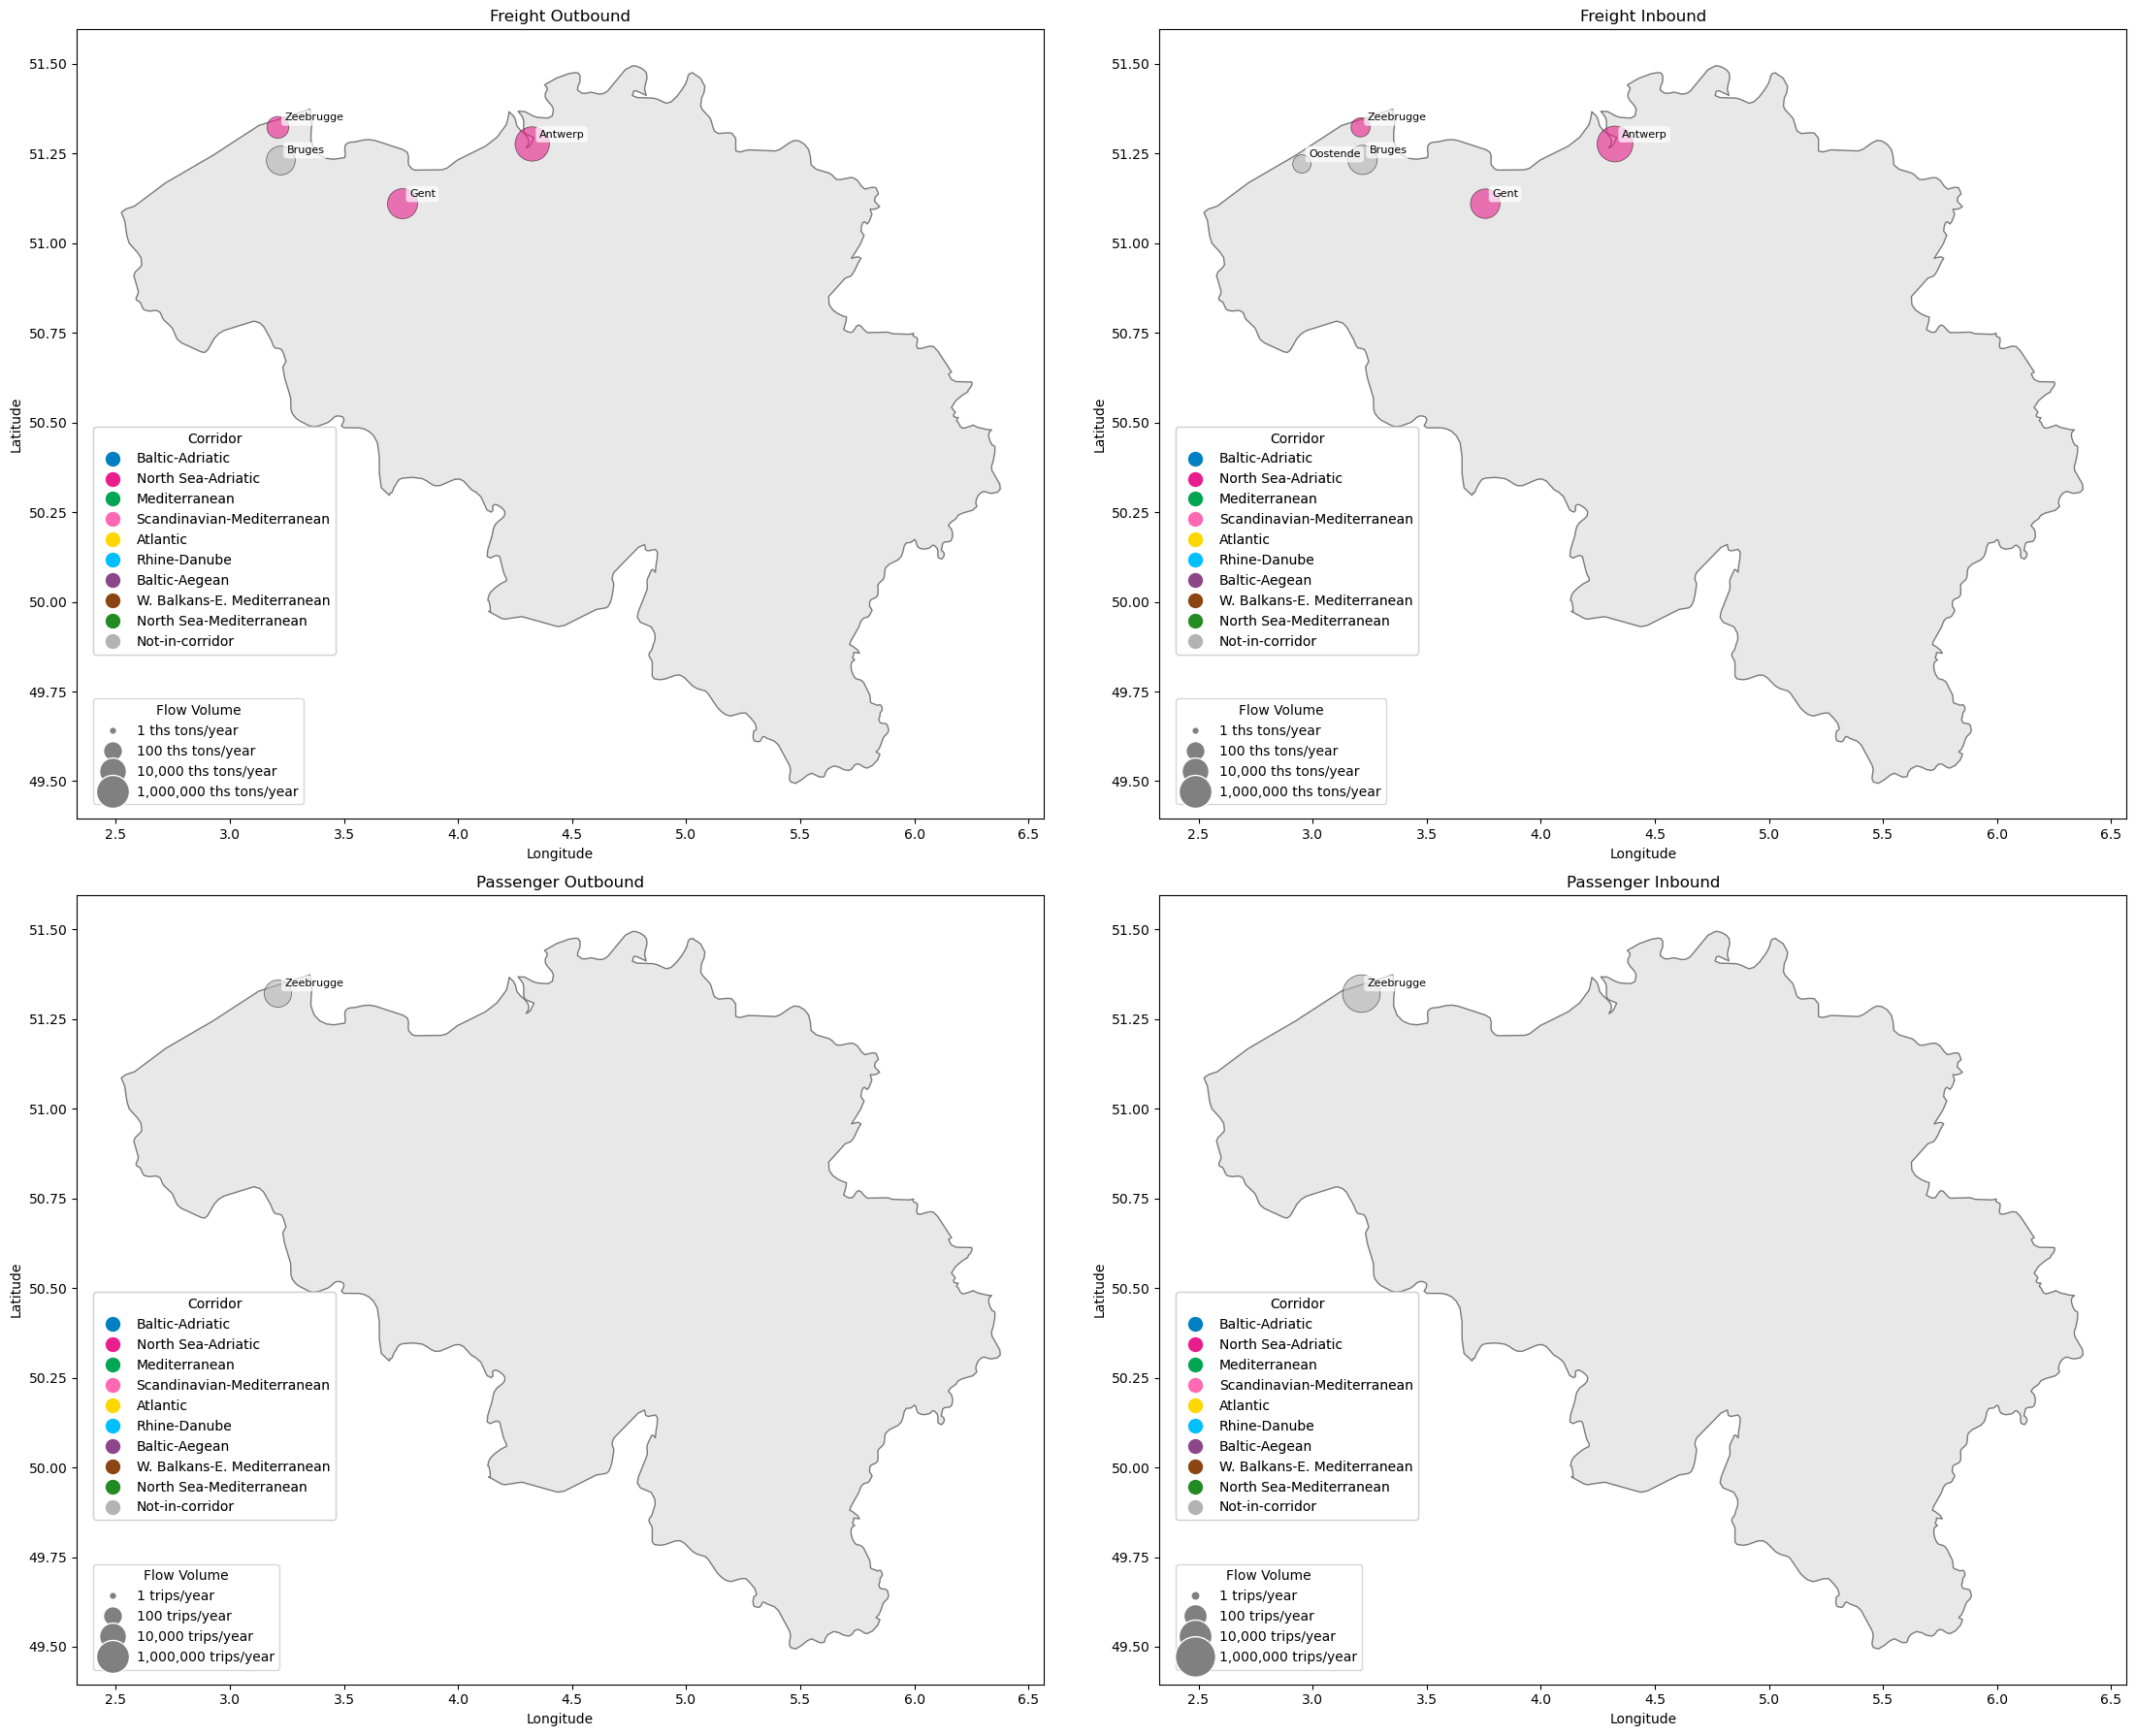

In [6]:
print("Generating bubble map subplots...")
country_name='BELGIUM'
fig, axes = plt.subplots(2, 2, figsize=(24, 18))
axes = axes.flatten()

# 1. Freight Outbound
plot_bubble_map(
    axes[0], country_ports_flow, 'outbound_flow', 'CORRIDORS', country_row, SELECTED_COUNTRY,
    'Outbound', 'Freight', outpath, scale_factor=100, flow_values=[1, 100, 10000, 1000000]
)
axes[0].set_title('Freight Outbound')

# 2. Freight Inbound
plot_bubble_map(
    axes[1], country_ports_flow, 'inbound_flow', 'CORRIDORS', country_row, SELECTED_COUNTRY,
    'Inbound', 'Freight', outpath, scale_factor=100, flow_values=[1, 100, 10000, 1000000]
)
axes[1].set_title('Freight Inbound')

# 3. Passenger Outbound
plot_bubble_map(
    axes[2], country_ports_passengers, 'outbound_passengers', 'CORRIDORS', country_row, SELECTED_COUNTRY,
    'Outbound', 'Passenger', outpath, scale_factor=100, flow_values=[1, 100, 10000, 1000000]
)
axes[2].set_title('Passenger Outbound')

# 4. Passenger Inbound
plot_bubble_map(
    axes[3], country_ports_passengers, 'inbound_passengers', 'CORRIDORS', country_row, SELECTED_COUNTRY,
    'Inbound', 'Passenger', outpath, scale_factor=150, flow_values=[1, 100, 10000, 1000000]
)
axes[3].set_title('Passenger Inbound')

filename = f'Maritime_bubbles_{country_name.replace(" ", "_")}.png'
plt.savefig(outpath / filename, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## 5. Summary Statistics

This section provides summary statistics for the selected country's maritime infrastructure and flows. It reports the number of ports, total inbound and outbound freight and passenger flows, and net flows, offering a concise overview of the country's maritime activity.

In [5]:
print("="*60)
print(f"SUMMARY FOR {SELECTED_COUNTRY}")
print("="*60)
print(f"\nInfrastructure:")
print(f"  Ports: {len(country_ports)}")

print(f"\nMaritime Freight Flows:")
print(f"  Ports with inbound flow: {(country_ports_flow['inbound_flow'] > 0).sum()}")
print(f"  Ports with outbound flow: {(country_ports_flow['outbound_flow'] > 0).sum()}")
print(f"  Total inbound: {country_ports_flow['inbound_flow'].sum():,.0f} tons/day")
print(f"  Total outbound: {country_ports_flow['outbound_flow'].sum():,.0f} tons/day")
print(f"  Net flow: {(country_ports_flow['outbound_flow'].sum() - country_ports_flow['inbound_flow'].sum()):,.0f} tons/day")

print(f"\nMaritime Passenger Flows:")
print(f"  Ports with inbound flow: {(country_ports_passengers['inbound_passengers'] > 0).sum()}")
print(f"  Ports with outbound flow: {(country_ports_passengers['outbound_passengers'] > 0).sum()}")
print(f"  Total inbound: {country_ports_passengers['inbound_passengers'].sum():,.0f} passengers/day")
print(f"  Total outbound: {country_ports_passengers['outbound_passengers'].sum():,.0f} passengers/day")
print(f"  Net flow: {(country_ports_passengers['outbound_passengers'].sum() - country_ports_passengers['inbound_passengers'].sum()):,.0f} passengers/day")

print("="*60)

SUMMARY FOR Belgium

Infrastructure:
  Ports: 238

Maritime Freight Flows:
  Ports with inbound flow: 5
  Ports with outbound flow: 4
  Total inbound: 11,635,683 tons/day
  Total outbound: 3,364,819 tons/day
  Net flow: -8,270,863 tons/day

Maritime Passenger Flows:
  Ports with inbound flow: 1
  Ports with outbound flow: 1
  Total inbound: 153,431 passengers/day
  Total outbound: 12,424 passengers/day
  Net flow: -141,007 passengers/day
